Disclaimer: This is warmup is heavily influenced by MMDetection's Instance Segmentation demo. Thanks MMCV team for the wonderful and clear notebook.

# Instance Segmentation using MMDetection Framework

In this warmup exercise, you will have an hands-on experience with:
- The dataset you've been provided
- Training and finetuning Mask R-CNN
- Exporting COCO-style instance segmentation outputs.

# Let's check if we have CUDA environment up and running.

In [1]:

# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Jun__8_16:49:14_PDT_2022
Cuda compilation tools, release 11.7, V11.7.99
Build cuda_11.7.r11.7/compiler.31442593_0
gcc (Ubuntu 11.3.0-1ubuntu1~22.04) 11.3.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



## Now, we need to get MMDetection along with PyTorch, Torchvision and MMCV.

In [ ]:
# install dependencies: (use cu111 because colab has CUDA 11.1)
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

# install mmcv-full thus we could use CUDA operators
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html

# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!pip install -e .

## Let's check the torch installation.

In [2]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.13.0 True


2.26.0
11.7
GCC 11.3


### Initialization of the framework and model

In this warmup, we will use Mask R-CNN, a simple yet efficient two stage detection network for both object detection and instance segmentation downstream tasks. Here is an overwiev of the architecture:

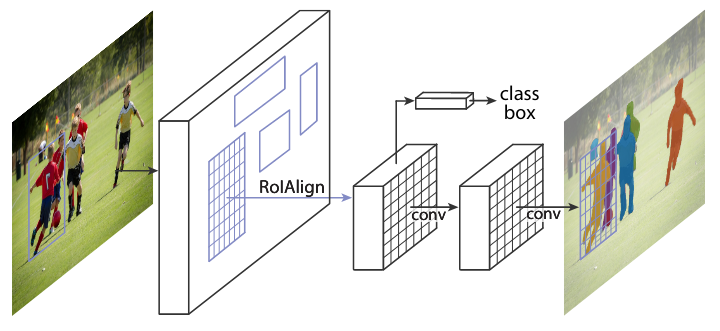

You can learn more about Mask R-CNN at: https://arxiv.org/abs/1703.06870

We first, need an mmdetection config that defines the training hyper-parameters. Some of them are:
- Dataset configuration
- Augmentations
- Optimizer
- Scheduler
- Model configuration
- Loggers
- Evaluation procedure
etc.

You can find more information at https://mmdetection.readthedocs.io/en/latest/tutorials/config.html.

Now let's load a config that mmdetection repo has for Mask R-CNN

In [13]:
config_file = 'configs/mask_rcnn/mask_rcnn_r50_fpn_1x_coco.py'

import mmcv

cfg = mmcv.Config.fromfile(config_file)
print(cfg.dump())

model = dict(
    type='MaskRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0)

Everything seems great. Notebook does not show the whole config, and that's for our own good. You can explore different parts of the config by treating it like a python dictionary, or just navigating to the downloaded config file.

In [14]:
cfg['model']

{'type': 'MaskRCNN',
 'backbone': {'type': 'ResNet',
  'depth': 50,
  'num_stages': 4,
  'out_indices': (0, 1, 2, 3),
  'frozen_stages': 1,
  'norm_cfg': {'type': 'BN', 'requires_grad': True},
  'norm_eval': True,
  'style': 'pytorch',
  'init_cfg': {'type': 'Pretrained', 'checkpoint': 'torchvision://resnet50'}},
 'neck': {'type': 'FPN',
  'in_channels': [256, 512, 1024, 2048],
  'out_channels': 256,
  'num_outs': 5},
 'rpn_head': {'type': 'RPNHead',
  'in_channels': 256,
  'feat_channels': 256,
  'anchor_generator': {'type': 'AnchorGenerator',
   'scales': [8],
   'ratios': [0.5, 1.0, 2.0],
   'strides': [4, 8, 16, 32, 64]},
  'bbox_coder': {'type': 'DeltaXYWHBBoxCoder',
   'target_means': [0.0, 0.0, 0.0, 0.0],
   'target_stds': [1.0, 1.0, 1.0, 1.0]},
  'loss_cls': {'type': 'CrossEntropyLoss',
   'use_sigmoid': True,
   'loss_weight': 1.0},
  'loss_bbox': {'type': 'L1Loss', 'loss_weight': 1.0}},
 'roi_head': {'type': 'StandardRoIHead',
  'bbox_roi_extractor': {'type': 'SingleRoIExtrac

Now, let's build our model and other hyper-parameters with the given config.

In [15]:
from mmdet.apis import init_detector
import torch

# This is already given in the config but putting it anyways just in case you don't have GPU.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

checkpoint = 'https://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_fpn_1x_coco/mask_rcnn_r50_fpn_1x_coco_20200205-d4b0c5d6.pth'

model = init_detector(cfg, checkpoint, device)

load checkpoint from http path: https://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_fpn_1x_coco/mask_rcnn_r50_fpn_1x_coco_20200205-d4b0c5d6.pth


Downloading: "https://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_fpn_1x_coco/mask_rcnn_r50_fpn_1x_coco_20200205-d4b0c5d6.pth" to /home/furkankucuk/.cache/torch/hub/checkpoints/mask_rcnn_r50_fpn_1x_coco_20200205-d4b0c5d6.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

Just like that. We could initialize our model in a more specific way, but `init_detector` function will do the most things for us. Now let's see a result.

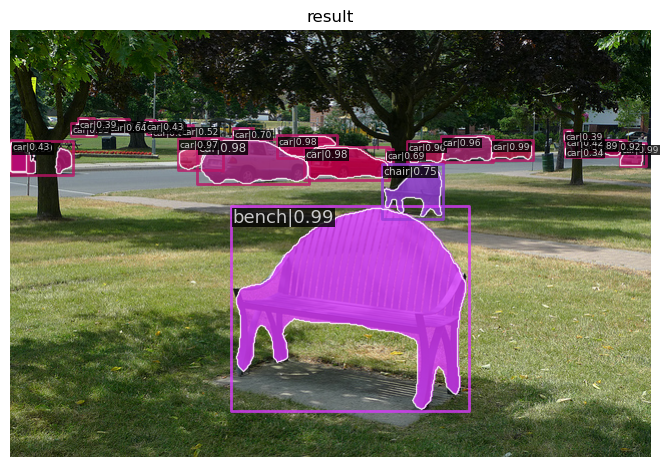

In [19]:
from mmdet.apis import inference_detector, show_result_pyplot
result = inference_detector(model, 'demo.jpg')
show_result_pyplot(model, 'demo.jpg', result, score_thr=.3)

## Training/Finetuning the model

We also can train the very same model. However, we need to keep an eye on the output size of the heads. COCO has 80 classes, while we have only 5. We need to make changes accordingly.

Luckily, we already have those changes within our config. We made our config available to you for your convinience. Let's download and load that config.

In [35]:
# some wget stuff.

cfg = mmcv.Config.fromfile('mmdet_config.py')
cfg.model.roi_head.bbox_head

{'type': 'Shared2FCBBoxHead',
 'in_channels': 256,
 'fc_out_channels': 1024,
 'roi_feat_size': 7,
 'num_classes': 4,
 'bbox_coder': {'type': 'DeltaXYWHBBoxCoder',
  'target_means': [0.0, 0.0, 0.0, 0.0],
  'target_stds': [0.1, 0.1, 0.2, 0.2]},
 'reg_class_agnostic': False,
 'loss_cls': {'type': 'CrossEntropyLoss',
  'use_sigmoid': False,
  'loss_weight': 1.0},
 'loss_bbox': {'type': 'L1Loss', 'loss_weight': 1.0}}

As you can see, one of the changes we made is `num_classes` parameter. Now, let's build the rest of the things we need.

In [48]:
from mmdet.datasets import build_dataset, CocoDataset, build_dataloader
from mmdet.models import build_detector
from mmdet.apis import train_detector
import os.path as osp
from mmcv.runner import load_checkpoint

# Doing this because those classes are hardcoded
CocoDataset.CLASSES = cfg.classes

# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(cfg.model)

# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

load_checkpoint(model, checkpoint, device)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
load checkpoint from http path: https://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_fpn_1x_coco/mask_rcnn_r50_fpn_1x_coco_20200205-d4b0c5d6.pth
The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([5, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([5]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([16, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([16]).
size mismatch for roi_head.mask_hea

{'meta': {'mmdet_version': '1.0rc1+d1c761c',
  'config': "# model settings\nmodel = dict(\n    type='MaskRCNN',\n    pretrained='torchvision://resnet50',\n    backbone=dict(\n        type='ResNet',\n        depth=50,\n        num_stages=4,\n        out_indices=(0, 1, 2, 3),\n        frozen_stages=1,\n        style='pytorch'),\n    neck=dict(\n        type='FPN',\n        in_channels=[256, 512, 1024, 2048],\n        out_channels=256,\n        num_outs=5),\n    rpn_head=dict(\n        type='RPNHead',\n        in_channels=256,\n        feat_channels=256,\n        anchor_scales=[8],\n        anchor_ratios=[0.5, 1.0, 2.0],\n        anchor_strides=[4, 8, 16, 32, 64],\n        target_means=[.0, .0, .0, .0],\n        target_stds=[1.0, 1.0, 1.0, 1.0],\n        loss_cls=dict(\n            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0),\n        loss_bbox=dict(type='SmoothL1Loss', beta=0.0, loss_weight=1.0)),\n    roi_head=dict(\n        type='BaseRoIHead',\n        bbox_roi_extracto

As it can be seen, we cannot load the whole model since we changed the detection heads for our needs, and that's fine. Let's do some training now!

In [46]:
train_detector(model, datasets, cfg, distributed=False, validate=True)

2023-01-29 23:50:30,577 - dbdetection - INFO - Automatic scaling of learning rate (LR) has been disabled.
2023-01-29 23:50:30,579 - dbdetection - INFO - Start running, host: furkankucuk@pop-os, work_dir: /home/furkankucuk/Documents/cvpr23_challenge/warmup/work_dirs/mask_rcnn_r50_fpn_1x_wandb_coco
2023-01-29 23:50:30,580 - dbdetection - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
(VERY_LOW    ) TensorboardLoggerHook              
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) NumClassCheckHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
(VERY_LOW    ) TensorboardLoggerHook       

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


2023-01-29 23:51:03,440 - dbdetection - INFO - Epoch [1][50/83]	lr: 1.978e-03, eta: 0:01:16, time: 0.655, data_time: 0.066, memory: 5784, loss_rpn_cls: 0.0315, loss_rpn_bbox: 0.0123, loss_cls: 0.3731, acc: 91.1274, loss_bbox: 0.2736, loss_mask: 0.5444, loss: 1.2350
2023-01-29 23:51:23,490 - dbdetection - INFO - Saving checkpoint at 1 epochs


OutOfMemoryError: CUDA out of memory. Tried to allocate 396.00 MiB (GPU 0; 7.79 GiB total capacity; 5.35 GiB already allocated; 520.38 MiB free; 5.85 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

You can examine your tensorboard logs with the following lines

In [47]:
# load tensorboard in colab
%load_ext tensorboard

# see curves in tensorboard
%tensorboard --logdir ./{cfg.work_dir}

### Let's see where we are at

In [ ]:
img = mmcv.imread('balloon/train/7178882742_f090f3ce56_k.jpg')

result = inference_detector(model, img)
show_result_pyplot(model, img, result)

### Now, let's have a COCO formatted output

In [ ]:
from mmdet.apis import single_gpu_test
from mmdet.utils import build_dp
import json

# Create test dataloader
test_dataloader_default_args = dict(
        samples_per_gpu=1, workers_per_gpu=2, dist=False, shuffle=False)

test_loader_cfg = {
        **test_dataloader_default_args,
        **cfg.data.get('val_dataloader', {})
    }
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(dataset, **test_loader_cfg)

# You can load or initialize your model here. Since we already trained our model within this notebook, I skip it.
# model = init_detector(cfg, checkpoint_file, device='cuda:0')
model.eval()

# Initialize and distribute your model
model = build_dp(model, "cuda", device_ids=[0])

# Run inference through your test dataloader and obtain list of results
outputs = single_gpu_test(model, data_loader)

# Generate json-formatted results with the help of MMDet's helper function.
outputs_json = dataset._segm2json(outputs)[1]

# Dump that json to a json file
with open("outputs.json", "w") as f:
    json.dump(outputs_json, f)

Now, you can explore the `outputs.json` file.

# It's your turn now!

You can experiment with that one, or build your own using the framework you like.